In [279]:
import os
import math
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import matplotlib.pyplot as plt

In [280]:
tokens = np.array(()) # empty numpy array
for filename in os.listdir('Dataset_tokenized_BPE'): # iterate through all files in the folder
    if filename.endswith('.npy'): # if the file is a .npy file
        for i in range(len(np.load(('Dataset_tokenized_BPE/' + filename), allow_pickle=True)[()].get('tokens'))): # iterate through all the tokens in the file
            tokens = np.append(tokens, 89) # append the start token
            tokens = np.append(tokens, np.load(('Dataset_tokenized_BPE/' + filename), allow_pickle=True)[()].get('tokens')[i]) # append the tokens of one piece to the numpy array
            tokens = np.append(tokens, 176) # append the end token
        continue 
    else: 
        continue 

In [287]:
print("smallest token:{}, biggest token:{}, number of tokens:{}, missing tokens:{}".format(np.min(tokens),np.max(tokens),np.unique(tokens).shape,set(range(0, 500))-set(tokens))) # print some information about the tokens
vocab_size = int(np.max(tokens)) + 1 # get the size of the vocabulary
# unique, counts = np.unique(tokens, return_counts=True)
# print(dict(zip(unique, counts))) # print the number of occurences of each token
data = tf.cast(tokens, tf.int32) # put tokens into a tensor and cast to int32
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n] # first 90% of data
val_data = data[n:] # last 10% of data

def split_input_target(chunk): # split the input and the target
    input_text = chunk[:-1] # input is the sequence without the last token
    target_text = chunk[1:] # target is the sequence without the first token
    return input_text, target_text

def make_batches(ds):
    return ds.shuffle(4096).batch(batch_size).prefetch(tf.data.AUTOTUNE)


smallest token:1.0, biggest token:499.0, number of tokens:(495,), missing tokens:{0, 178, 180, 182, 186}


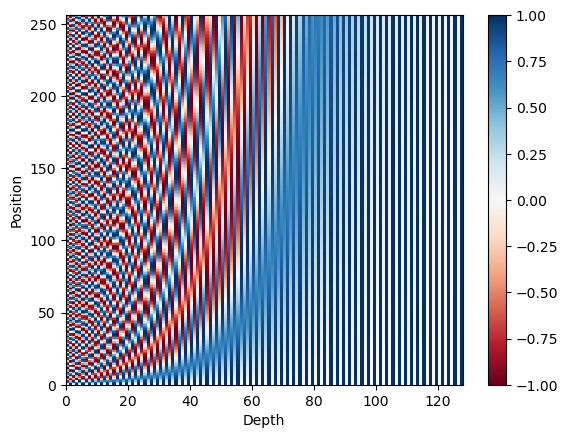

In [282]:
# postional encoding function
def positional_encoding(length, d_model):
    pos = np.arange(length)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(seq_length, d_model)

# plot the positional encoding
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# layer for embedding and positional encoding
class PostionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, block_size):
        super(PostionalEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.block_size = block_size
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, 
                          output_dim=d_model, # each token gets a 512-vector embedding
                          input_length=block_size)
        self.pos_encoding = positional_encoding(block_size, d_model)
        
    def call(self, x):
        return self.embedding(x) + self.pos_encoding[:, :self.block_size, :]

In [283]:
# dot-product attention
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads):
        super(ScaledDotProductAttention, self).__init__()
        self.head_size = d_model // n_heads
        self.key = tf.keras.layers.Dense(units=self.head_size, use_bias=False)
        self.query = tf.keras.layers.Dense(units=self.head_size, use_bias=False)
        self.value = tf.keras.layers.Dense(units=self.head_size, use_bias=False)

    @tf.function
    def call(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        # compute scores
        scores = tf.matmul(q,tf.transpose(k, perm=[0, 2, 1])) / tf.math.sqrt(tf.cast(self.head_size, tf.float32))
        tril = tf.linalg.band_part(tf.ones((T, T)), -1, 0)
        scores = tf.where(tril == 0, tf.fill(tril.shape, -float('inf')), scores)
        scores = tf.nn.softmax(scores, axis=-1)
        # weighted sum of values
        v = self.value(x)
        return tf.matmul(scores, v)

# multi-head attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.heads = [ScaledDotProductAttention(d_model, n_heads) for _ in range(n_heads)]
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    @tf.function
    def call(self, x):
        x = tf.concat([head(x) for head in self.heads], axis=-1)
        return self.dense(x)
    
# feed-forward network
class FeedForwardNetwork(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate):
        super(FeedForwardNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=dff, activation=tf.nn.gelu)
        self.dense2 = tf.keras.layers.Dense(units=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    @tf.function
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dropout(x)
        return x

# decoder layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dff, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ffn = FeedForwardNetwork(d_model, dff, dropout_rate)
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
    
    @tf.function
    def call(self, x):
        res_x = x
        x = self.layernorm1(x)
        x = self.mha(x)
        x = self.add([res_x, x])
        res_x = x
        x = self.layernorm2(x)
        x = self.ffn(x)
        x = self.add([res_x, x])
        return x
    
# decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size):
        super(Decoder, self).__init__()
        self.embedding = PostionalEmbedding(vocab_size, d_model, block_size)
        self.layers = [DecoderLayer(d_model, n_heads, dff, dropout_rate) for _ in range(n_layers)]

    
    @tf.function
    def call(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        return x
    
# transformer
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size):
        super(Transformer, self).__init__()
        self.decoder = Decoder(vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, block_size)
        self.final_dense = tf.keras.layers.Dense(units=vocab_size)
    
    @tf.function
    def call(self, x):
        x = self.decoder(x)
        logits = self.final_dense(x)
            
        try:      
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [284]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [294]:
d_model = 128 # also embedding size
dff = 512 # inner feedforward layer dim
n_heads = 8 # number of heads in the multihead attention layer
d_v, d_q, d_k = d_model // n_heads , d_model // n_heads , d_model // n_heads # dimension of the query, key and value vectors 
n_layers = 4 # number of layers
dropout_rate = 0.1 # dropout rate
epochs = 50
seq_length = 256 # length of the sequence
batch_size = 64 # batch size

In [295]:
train_ds = tf.data.Dataset.from_tensor_slices(train_data) # create a dataset from the train data
val_ds = tf.data.Dataset.from_tensor_slices(val_data) # create a dataset from the val data
train_ds = train_ds.batch(seq_length+1, drop_remainder=True).map(split_input_target)
val_ds = val_ds.batch(seq_length+1, drop_remainder=True).map(split_input_target)
train_ds = make_batches(train_ds)
val_ds = make_batches(val_ds)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

model = Transformer(vocab_size, d_model, n_heads, dff, dropout_rate, n_layers, seq_length)

model.compile(optimizer=optimizer, loss=masked_loss, metrics=[masked_accuracy])

model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/50
100/100 [==============================] - 64s 389ms/step - loss: 6.8943 - masked_accuracy: 0.0032 - val_loss: 6.1623 - val_masked_accuracy: 0.0087
Epoch 2/50
100/100 [==============================] - 38s 371ms/step - loss: 5.9074 - masked_accuracy: 0.0098 - val_loss: 5.7289 - val_masked_accuracy: 0.0098
Epoch 3/50
100/100 [==============================] - 39s 373ms/step - loss: 5.6197 - masked_accuracy: 0.0109 - val_loss: 5.6313 - val_masked_accuracy: 0.0106
Epoch 4/50
100/100 [==============================] - 39s 375ms/step - loss: 5.5586 - masked_accuracy: 0.0127 - val_loss: 5.5700 - val_masked_accuracy: 0.0171
Epoch 5/50
100/100 [==============================] - 38s 369ms/step - loss: 5.4494 - masked_accuracy: 0.0177 - val_loss: 5.4646 - val_masked_accuracy: 0.0183
Epoch 6/50
100/100 [==============================] - 38s 369ms/step - loss: 5.3061 - masked_accuracy: 0.0231 - val_loss: 5.3030 - val_masked_accuracy: 0.0237
Epoch 7/50
100/100 [==========================